#  Exploratory Data Analysis (EDA) - Pima Indians Diabetes Dataset


Bộ dữ liệu **Pima Indians Diabetes** được sử dụng rộng rãi trong nghiên cứu y học và trí tuệ nhân tạo.  
Theo các báo cáo kinh điển (WHO 1999, NDDG 1979), việc chẩn đoán và phân loại bệnh đái tháo đường dựa trên các đặc điểm lâm sàng, xét nghiệm đường huyết, và các yếu tố nguy cơ.  

Ngoài ra, nghiên cứu của Smith et al. (1988)- paper 2 đã áp dụng **mạng nơ-ron ADAP** để dự đoán nguy cơ mắc tiểu đường trên chính bộ dữ liệu này.  

Trong notebook này, chúng ta sẽ:  
1. Xác định tính chất dữ liệu  
2. Phân tích đơn biến  
3. Phân tích đa biến  
4. Xác định giá trị thiếu & mẫu bất thường  
5. Xác định ngoại lệ (outliers)  
6. Xử lý missing values và xuất bộ dữ liệu sạch  
    

## 1. Load dataset & Kiểm tra thông tin (Xác định tính chất dữ liệu)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


sns.set(style="whitegrid")

# Đọc dữ liệu
file_path = "pima-indians-diabetes.csv"   # chỉnh lại nếu cần
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
           "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(file_path, header=None)
df.columns = columns

print(" Kích thước dữ liệu:", df.shape)
print(df.info())
df.head()


 Kích thước dữ liệu: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1


- Bộ dữ liệu gồm 768 dòng, 9 cột (8 đặc trưng + 1 nhãn `Outcome`).  
- Các biến như `Glucose`, `BloodPressure`, `BMI` liên quan trực tiếp đến tiêu chuẩn chẩn đoán tiểu đường do WHO và NDDG đề xuất.  
- `Outcome = 1` nghĩa là bệnh nhân mắc tiểu đường, `0` là không mắc.  
    

## 2. Xác định giá trị thiếu

In [2]:

zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

print("Số lượng giá trị 0 (coi là missing):")
for c in zero_as_missing_cols:
    print(f"{c}: {(df[c]==0).sum()}")

# Thay 0 bằng NaN
df2 = df.copy()
for c in zero_as_missing_cols:
    df2[c] = df2[c].replace(0, np.nan)

print("\n Missing values sau khi thay 0 -> NaN:")
print(df2.isnull().sum())

df2.describe()


Số lượng giá trị 0 (coi là missing):
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11

 Missing values sau khi thay 0 -> NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  763.000000     733.000000     541.000000  394.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.535641      12.382158      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  141.000000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  757.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.924988                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000


- Trong dữ liệu, một số cột có giá trị `0` không hợp lý về mặt y học (ví dụ: Glucose = 0).  
- Theo chuẩn chẩn đoán WHO, glucose máu lúc đói ≥ 7.0 mmol/L (126 mg/dL) mới chẩn đoán là đái tháo đường → không thể có giá trị 0.  
- Do đó, ta coi các giá trị 0 là **missing** và thay bằng `NaN`.  
    

## 3. Phân tích đơn biến (Univariate Analysis)

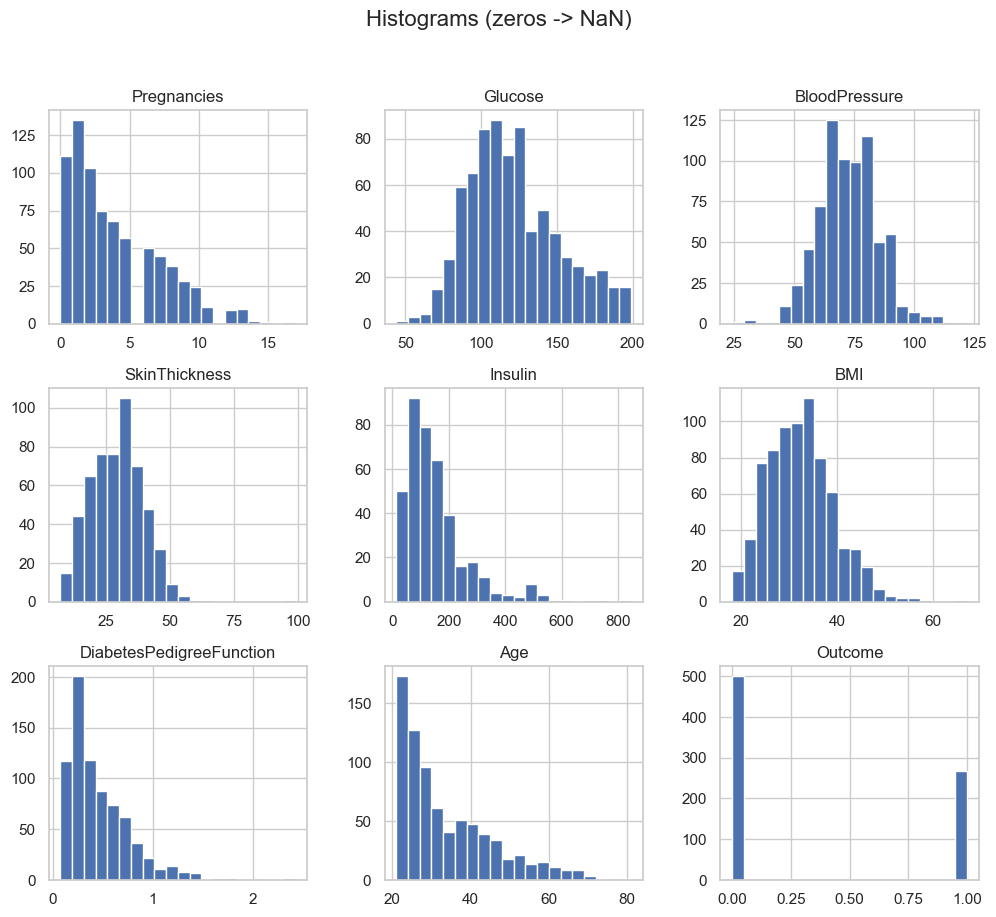

In [3]:

df2.hist(bins=20, figsize=(12,10))
plt.suptitle("Histograms (zeros -> NaN)", fontsize=16)
plt.show()



- Histogram cho thấy phân phối của từng biến.  
- Các biến như `Age`, `Pregnancies`, `BMI` có phân phối lệch phải.  
- Đây là thông tin quan trọng để xác định ngưỡng bất thường và thiết kế mô hình dự đoán.  
    

## 4. Phân tích đa biến (Multivariate Analysis)

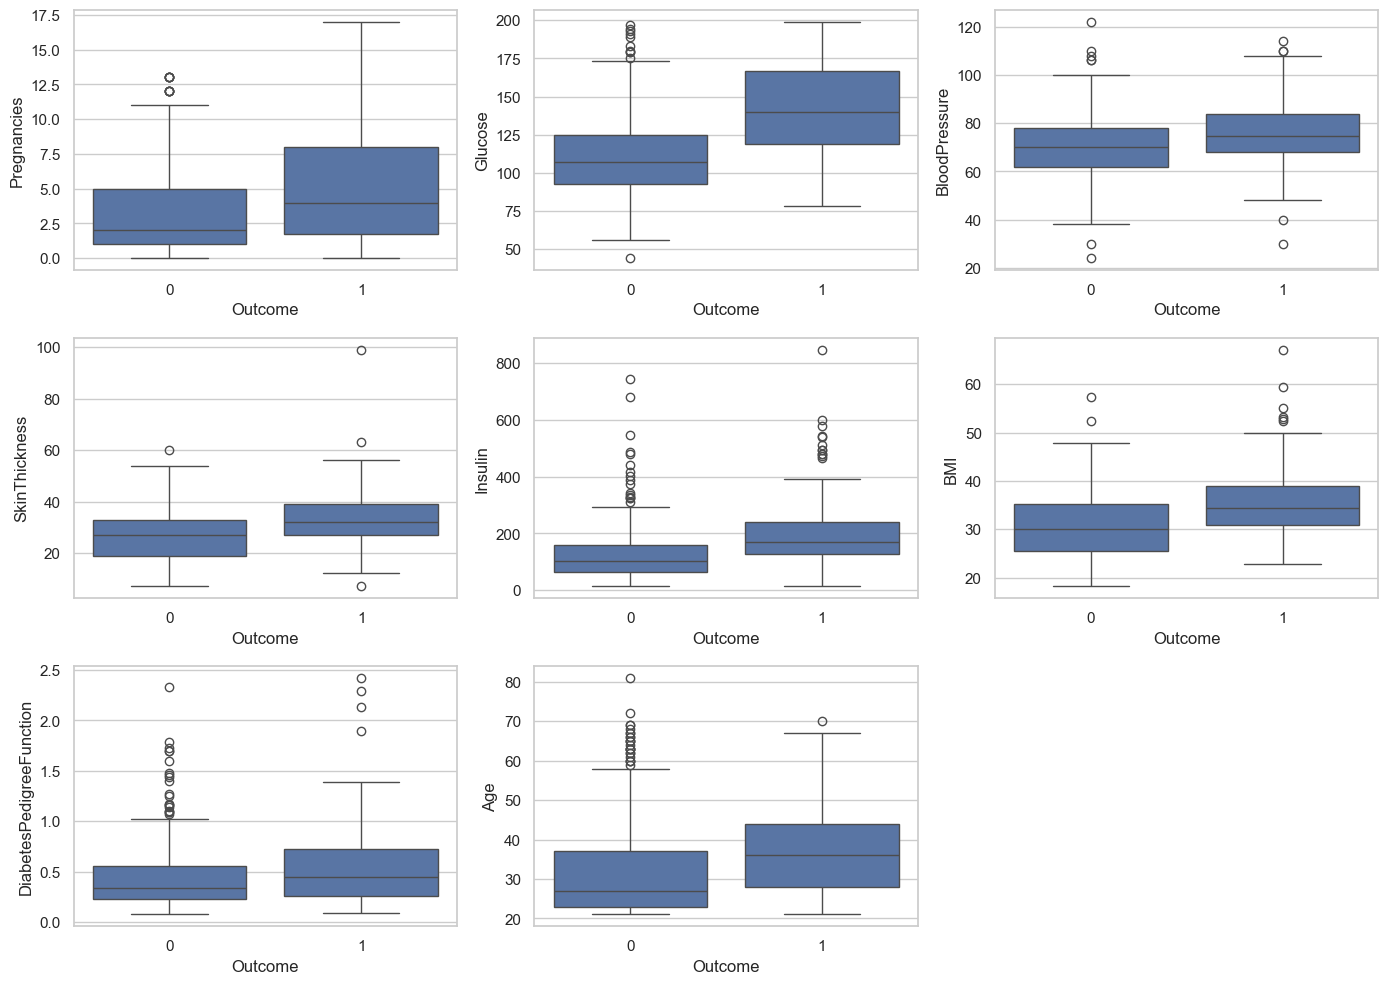

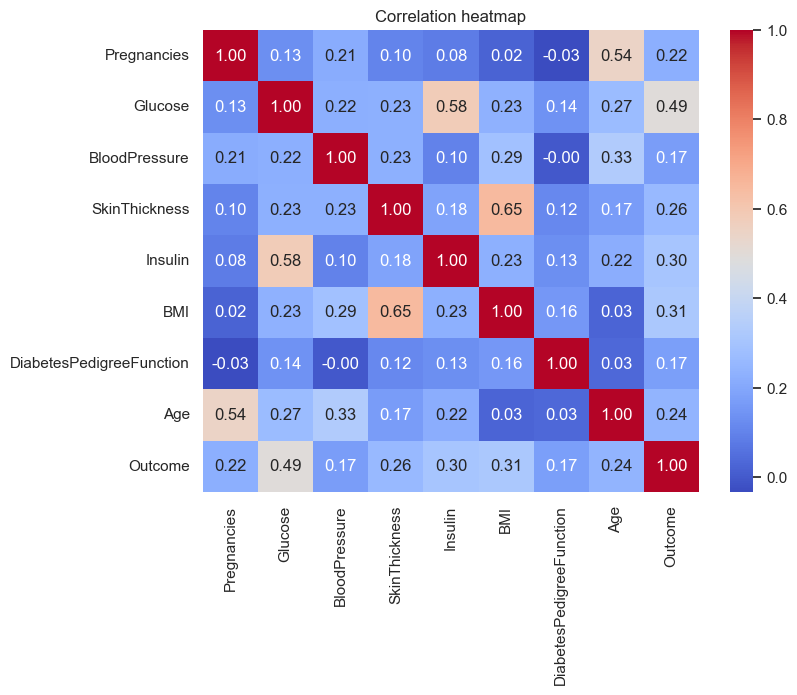

In [4]:

# Boxplot theo Outcome
plt.figure(figsize=(14,10))
num_cols = [c for c in df2.columns if c!="Outcome"]
for i, c in enumerate(num_cols, 1):
    plt.subplot(3,3,i)
    sns.boxplot(data=df2, x="Outcome", y=c)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df2.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()



- Boxplot giúp so sánh phân phối các biến giữa nhóm mắc và không mắc tiểu đường.  
- Correlation heatmap cho thấy **Glucose** có tương quan cao nhất với `Outcome`, phù hợp với tiêu chuẩn chẩn đoán y tế.  
- Các yếu tố như tuổi và BMI cũng là nguy cơ cao (theo WHO - paper 1 và NDDG- paper 3).  
    

## 5. Phát hiện ngoại lệ (Outlier Detection - IQR)

In [5]:

def detect_outliers_iqr(series):
    s = series.dropna()
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), lower, upper

for c in num_cols:
    n_out, lo, up = detect_outliers_iqr(df2[c])
    print(f"{c}: {n_out} ngoại lệ (ngưỡng < {lo:.2f} hoặc > {up:.2f})")


Pregnancies: 4 ngoại lệ (ngưỡng < -6.50 hoặc > 13.50)
Glucose: 0 ngoại lệ (ngưỡng < 36.00 hoặc > 204.00)
BloodPressure: 14 ngoại lệ (ngưỡng < 40.00 hoặc > 104.00)
SkinThickness: 3 ngoại lệ (ngưỡng < 1.00 hoặc > 57.00)
Insulin: 24 ngoại lệ (ngưỡng < -94.38 hoặc > 360.62)
BMI: 8 ngoại lệ (ngưỡng < 13.85 hoặc > 50.25)
DiabetesPedigreeFunction: 29 ngoại lệ (ngưỡng < -0.33 hoặc > 1.20)
Age: 9 ngoại lệ (ngưỡng < -1.50 hoặc > 66.50)



- Phát hiện ngoại lệ bằng phương pháp **IQR (Interquartile Range)**.  
- Ví dụ: `Insulin` có nhiều giá trị cực đoan → cần xem xét vì có thể là lỗi nhập liệu hoặc phản ánh phân phối thật.  
- Trong thực hành lâm sàng, WHO- paper 1 cũng khuyến cáo kiểm tra nhiều lần trước khi kết luận giá trị bất thường.  
    

## 6. Xử lý missing values (Imputation)

In [6]:

df_imputed = df2.copy()
for c in zero_as_missing_cols:
    median_val = df_imputed[c].median()
    df_imputed[c] = df_imputed[c].fillna(median_val)
    print(f"Imputed {c} with median = {median_val:.2f}")

print("\nMissing values sau imputation:")
print(df_imputed.isnull().sum())

# Lưu file mới
df_imputed.to_csv("pima_clean_imputed.csv", index=False)
print("Saved cleaned dataset to pima_clean_imputed.csv")


Imputed Glucose with median = 117.00
Imputed BloodPressure with median = 72.00
Imputed SkinThickness with median = 29.00
Imputed Insulin with median = 125.00
Imputed BMI with median = 32.30

Missing values sau imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Saved cleaned dataset to pima_clean_imputed.csv



 
- Dùng **median imputation** để thay thế giá trị thiếu, nhằm giảm ảnh hưởng của outliers.  
- Dataset sạch này có thể dùng để huấn luyện mô hình dự đoán như **logistic regression** hoặc **neural networks** .  
    

# 7. Phân bố Outcome


C:\Users\hienm\AppData\Local\Temp\ipykernel_23316\3989142145.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x="Outcome", palette="Set2")


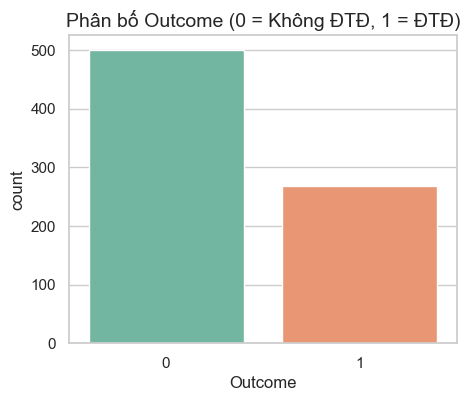

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(data=df2, x="Outcome", palette="Set2")
plt.title("Phân bố Outcome (0 = Không ĐTĐ, 1 = ĐTĐ)", fontsize=14)
plt.show()

- Vẽ số lượng mẫu có Outcome = 0 và 1.

- Giúp thấy class imbalance (ví dụ thường nhóm không tiểu đường nhiều hơn)

- Mục đích: hiểu sự cân bằng dữ liệu.

# 8. So sánh phân phối Glucose và BMI theo Outcome


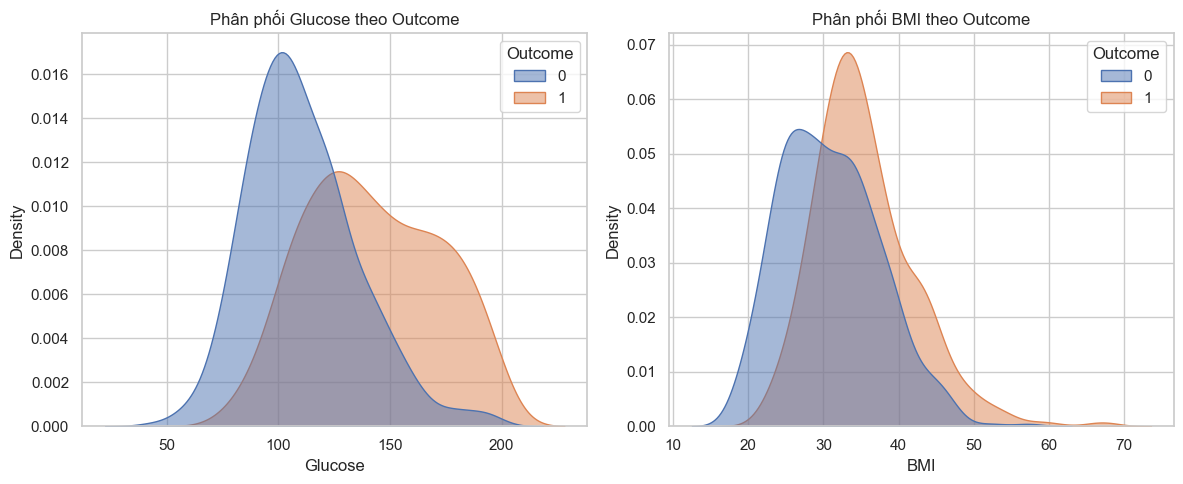

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=df2, x="Glucose", hue="Outcome", fill=True, common_norm=False, alpha=0.5)
plt.title("Phân phối Glucose theo Outcome")

plt.subplot(1,2,2)
sns.kdeplot(data=df2, x="BMI", hue="Outcome", fill=True, common_norm=False, alpha=0.5)
plt.title("Phân phối BMI theo Outcome")

plt.tight_layout()
plt.show()

- Vẽ KDE plot cho 2 biến quan trọng nhất: Glucose & BMI.

- Nhìn được sự khác biệt phân phối giữa 2 nhóm Outcome.

- Mục đích: thấy rõ đặc trưng của bệnh nhân tiểu đường vs không.

# 9. Scatter plot Glucose vs Age theo Outcome


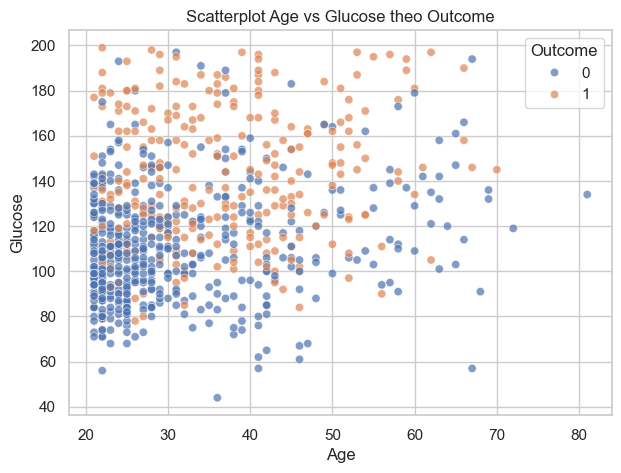

In [9]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df2, x="Age", y="Glucose", hue="Outcome", alpha=0.7)
plt.title("Scatterplot Age vs Glucose theo Outcome")
plt.show()

- Nhìn quan hệ giữa tuổi và mức glucose.

- Thấy xu hướng bệnh nhân lớn tuổi có Glucose cao hơn và dễ tiểu đường.

# 10. Pairplot cho vài biến chính


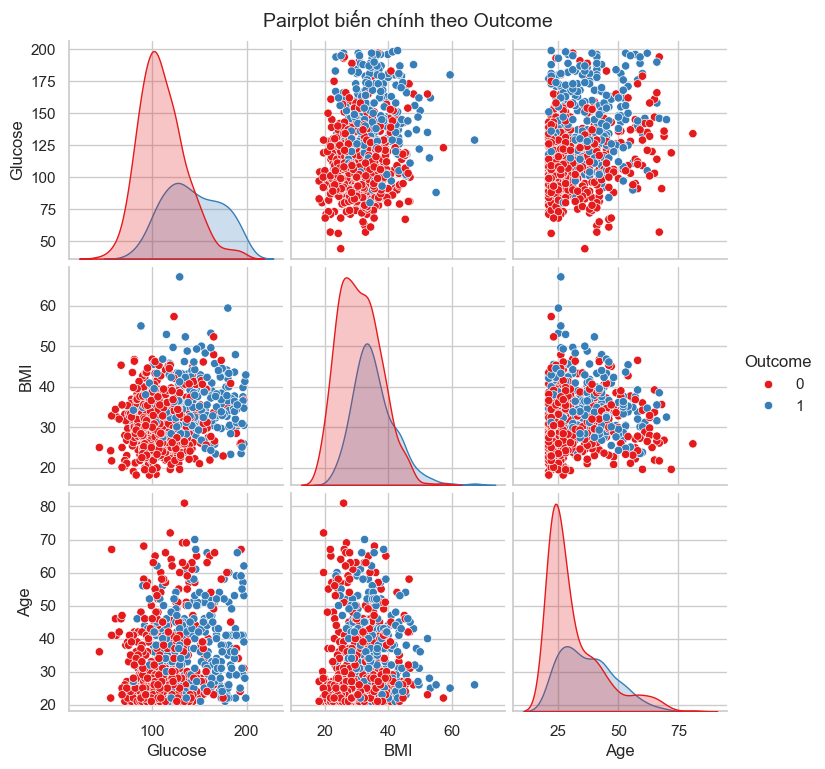

In [10]:
sns.pairplot(df2[["Glucose", "BMI", "Age", "Outcome"]], hue="Outcome", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot biến chính theo Outcome", y=1.02, fontsize=14)
plt.show()

- Ma trận scatter + KDE cho 3 biến chính và Outcome.

- Giúp trực quan hóa sự phân tách nhóm.

# 11. Phát hiện mẫu bất thường (Anomaly Detection)



Kết quả phát hiện anomaly:
anomaly
 1    729
-1     39
Name: count, dtype: int64

Một vài mẫu bất thường được phát hiện:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4             0    137.0           40.0           35.0    168.0  43.1   
8             2    197.0           70.0           45.0    543.0  30.5   
13            1    189.0           60.0           23.0    846.0  30.1   
18            1    103.0           30.0           38.0     83.0  43.3   
43            9    171.0          110.0           24.0    240.0  45.4   

    DiabetesPedigreeFunction  Age  Outcome  anomaly  
4                      2.288   33        1       -1  
8                      0.158   53        1       -1  
13                     0.398   59        1       -1  
18                     0.183   33        0       -1  
43                     0.721   54        1       -1  


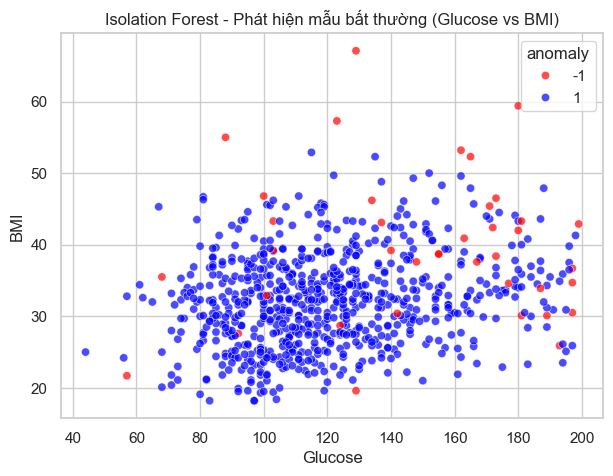

In [11]:
iso = IsolationForest(contamination=0.05, random_state=42)
df_imputed["anomaly"] = iso.fit_predict(df_imputed.drop(columns=["Outcome"]))

print("\nKết quả phát hiện anomaly:")
print(df_imputed["anomaly"].value_counts())  # 1 = normal, -1 = anomaly

print("\nMột vài mẫu bất thường được phát hiện:")
print(df_imputed[df_imputed["anomaly"]==-1].head())

# Trực quan hóa anomalies (Glucose vs BMI)
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_imputed, x="Glucose", y="BMI",
                hue="anomaly", palette={1:"blue", -1:"red"}, alpha=0.7)
plt.title("Isolation Forest - Phát hiện mẫu bất thường (Glucose vs BMI)")
plt.show()

 - Thuật toán Isolation Forest được dùng ở đây:
     + Ý tưởng: các điểm bất thường thường nằm xa cụm chính,
       nên dễ bị "cô lập" nhanh hơn trong các cây quyết định ngẫu nhiên.
     + Kết quả trả về: 1 = điểm bình thường, -1 = điểm bất thường.
 - Tham số contamination=0.05 nghĩa là giả định khoảng 5% dữ liệu là bất thường.
